## YOLOv3 Object Detection
"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, \
    Input, ZeroPadding2D, LeakyReLU, UpSampling2D
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

YOLOv3 needs two files for it's implementation, downloaded from the official YOLO website. yolov3.cfg file contains the YOLOv3 architecture and it's parameters and yolov3.weights constains the pre-trained weights for convolutional layers.

I am going to parse the configuration file and build the model as given in the file.

## Parsing the Configuration File

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

def parse_cfgfile(cfgfile):
    with open(cfgfile,'r') as f:
        #Removing the unnecessary characters such as "\n" and "#"
        lines = [line.rstrip('\n') for line in f if line != '\n' and line[0] != '#' ]
    holder = {}
    blocks = []
    #Looping over all the lines and storing layer type and it's parameters in blocks dict
    for line in lines:
        if line[0] == "[":
            line = "type= " + line[1:-1].rstrip()
            if len(holder) != 0:
                blocks.append(holder)
                holder = {}
        key, value = line.split('=')
        holder[key.rstrip()] = value.lstrip()
    blocks.append(holder)
    return blocks

## Developing the YOLO Model from the configuration file parsed above

In [ ]:
def YOLOv3net(cfgfile, img_size, num_classes):
    blocks = parse_cfgfile(cfgfile)
    
    outputs = {}
    output_filters = []
    filters = []
    out_pred = []
    scale = 0
    
    inputs = input_image = Input(shape=img_size)
    inputs = inputs/ 255.0
    
    #Loop over the blocks and build the layers according to the "type" and "parameters"
    for i, block in enumerate(blocks[1:]):
        
        #If it's a convolutional layer
        
        if (block["type"] == "convolutional"):
            
            activation = block["activation"]
            kernel_size = int(block['size'])
            filters = int(block['filters'])
            strides = int(block['stride'])
            
            if strides > 1:
                inputs = ZeroPadding2D(((1,0),(1,0)))(inputs)
                
            inputs = Conv2D(filters,
                            kernel_size,
                            strides=strides,
                            padding='valid' if strides > 1 else 'same',
                            name='conv_' + str(i),
                            use_bias=False if ("batch_normalize" in block) else True)(inputs)
            
            
            #Check for batch_normalization, then apply LeakyRelu
            
            if "batch_normalize" in block:
                inputs = BatchNormalization(name='bnorm_' + str(i))(inputs)
            if activation =='leaky':    
                inputs = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(inputs)
            
        # If it's a upsample layer
            
        elif (block['type'] == 'upsample'):
            stride = int(block['stride'])
            inputs = UpSampling2D(stride)(inputs)
            
        # If it's a route layer
            
        elif (block['type'] == 'route'):
            block['layers'] = block['layers'].split(",")
            start = int(block['layers'][0])
                
            if int(len(block['layers']) > 1):
                end = int(block['layers'][1]) - i
                filters = output_filters[i + start] + output_filters[end]
                inputs = tf.concat([outputs[i + start], outputs[i + end]], axis=-1)
            else:
                filters = output_filters[i + start]
                inputs = outputs[i + start]
            
        # If it's shortcut layer
            
        elif (block["type"] == 'shortcut'):
            from_ = int(block['from'])
            inputs = outputs[i-1] + outputs[i+from_]
                
        # If it's a YOLO layer
            
        elif (block["type"] == 'yolo'):
            mask = block['mask'].split(",")
            mask = [int(a) for a in mask]
            anchors = block['anchors'].split(',')
            anchors = [int(b) for b in anchors]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in mask]
            num_anchors = len(anchors)
            
            out_shape = inputs.get_shape().as_list()
            
            inputs = tf.reshape(inputs, [-1, num_anchors * out_shape[1] * out_shape[2],
                                      5 + num_classes])
            
            #Accessing boxes attributes
            box_centers = inputs[:, :, 0:2]
            box_shapes = inputs[:, :, 2:4]
            confidence = inputs[:, :, 4:5]
            
            #class scores
            classes = inputs[:, :, 5:num_classes + 5]
            
            #Refine Bounding Boxes
            
            box_centers = tf.sigmoid(box_centers)
            confidence = tf.sigmoid(confidence)
            classes = tf.sigmoid(classes)
            
            #Total output class predictions are num_achors x total grid cells
            
            anchors = tf.tile(anchors, [out_shape[1] * out_shape[2], 1])
            
            #Converting box_shapes
            
            box_shapes = tf.exp(box_shapes) * tf.cast(anchors, dtype=tf.float32)
            
            #Using meshgrid to convert relative positions of center boxes to the real positions
            x = tf.range(out_shape[1], dtype=tf.float32)
            y = tf.range(out_shape[2], dtype=tf.float32)
            cx, cy = tf.meshgrid(x, y)
            cx = tf.reshape(cx, (-1, 1))
            cy = tf.reshape(cy, (-1, 1))
            cxy = tf.concat([cx, cy], axis=-1)
            cxy = tf.tile(cxy, [1, num_anchors])
            cxy = tf.reshape(cxy, [1, -1, 2])
            strides = (input_image.shape[1] // out_shape[1], \
                       input_image.shape[2] // out_shape[2])
            box_centers = (box_centers + cxy) * strides
            
            #Concatenating box_shapes, confidence and class scores together
            
            prediction = tf.concat([box_centers, box_shapes, confidence, classes], axis=-1)
            #prediction = Lambda(lambda x: tf.concat(x[0], x[1]))([box_centers, box_shapes, confidence, classes], axis=-1)
            #YOLOv3 performs 3 prediction across 3 difference scales.
            #Taking the prediction result for each scale and concatenating wih others
            
            if scale:
                out_pred = tf.concat([out_pred, prediction], axis=1)
            else:
                out_pred = prediction
                scale = 1
            
        outputs[i]=inputs
        output_filters.append(filters)
    
    model = Model(input_image, out_pred)
    model.summary()
    
    return model

## Loading the weights from the weights file downloaded form official YOLO website

YOLOv3 weights file contains the weights for convolutional layers of the YOLO model in binary format. As we saw while parsing the configuration file, there are two types of convolutional layers, with and without a batch normalization layer. So, we need to be careful while extracting and applying the weights to the correct layers.   

In [ ]:
def load_weights(model,cfgfile,weightfile):
    # Open the weights file
    fp = open(weightfile, "rb")

    # Skip 5 header values
    np.fromfile(fp, dtype=np.int32, count=5)

    # The rest of the values are the weights
    blocks = parse_cfgfile(cfgfile)
    
    # As we did while developing the YOLO model, we need to loop over the 
    # configuration file and seach for the convolutional layers. We also need
    # need to check if convolutional layers is followed by batch normalization
    # layer or not. 
    for i, block in enumerate(blocks[1:]):

        if (block["type"] == "convolutional"):
            conv_layer = model.get_layer('conv_' + str(i))
            print("layer: ",i+1,conv_layer)

            filters = conv_layer.filters
            k_size = conv_layer.kernel_size[0]
            in_dim = conv_layer.input_shape[-1]

            if "batch_normalize" in block:

                norm_layer = model.get_layer('bnorm_' + str(i))
                print("layer: ",i+1,norm_layer)
                size = np.prod(norm_layer.get_weights()[0].shape)

                bn_weights = np.fromfile(fp, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            else:
                conv_bias = np.fromfile(fp, dtype=np.float32, count=filters)

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, k_size, k_size)
            conv_weights = np.fromfile(
                fp, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if "batch_normalize" in block:
                norm_layer.set_weights(bn_weights)
                conv_layer.set_weights([conv_weights])
            else:
                conv_layer.set_weights([conv_weights, conv_bias])

    # Adding the alert if file reading as failed and closing the file
    assert len(fp.read()) == 0, 'failed to read all data'
    fp.close()


weightfile = "weights/yolov3.weights"
cfgfile = "cfg/yolov3.cfg.txt"

model_size = (416, 416, 3)
num_classes = 80

model=YOLOv3net(cfgfile,model_size,num_classes)
load_weights(model,cfgfile,weightfile)

try:
    model.save_weights('weights/yolov3_weights.tf')
    print('\nThe file \'yolov3_weights.tf\' has been saved successfully.')
except IOError:
    print("Couldn't write the file \'yolov3_weights.tf\'.")




#### Defining and initializing YOLO model parameters

In [ ]:
#from utils import load_class_names, bounding_boxes, draw_boxes, resize_image

img_size = (416, 416,3)
num_classes = 80
class_name = './data/coco.names.txt'
max_output_size = 100
max_output_size_per_class= 20
iou_threshold = 0.5
confidence_threshold = 0.5

cfgfile = 'cfg/yolov3.cfg.txt'
weightfile = 'weights/yolov3_weights.tf'

#Loading the model and weights
model = YOLOv3net(cfgfile,img_size,num_classes)
model.load_weights(weightfile)

#Extracting class_names
class_names = load_class_names(class_name)

## Detecting objects in an image

In [ ]:
#Loading the image to test YOLO object detection
img_filename = "img/traffic.jpg"

#Preprocessing the image
image = cv2.imread(img_filename)
image = np.array(image)
image = tf.expand_dims(image, 0)

resized_image = resize_image(image, (img_size[0],img_size[1]))

prediction = model.predict(resized_image)

#Extracting the bounding box, scores and classes for the objects predicted in the image
boxes, scores, classes, nums = bounding_boxes( \
    prediction, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    confidence_threshold=confidence_threshold)

image = np.squeeze(image)

#Drawing the bounding boxes and captioning the box with the class name
img = draw_boxes(image, boxes, scores, classes, nums, class_names)

cv2.imshow('Object Detection',img)
cv2.waitKey(0)

## Detected Images with YOLOv3 model

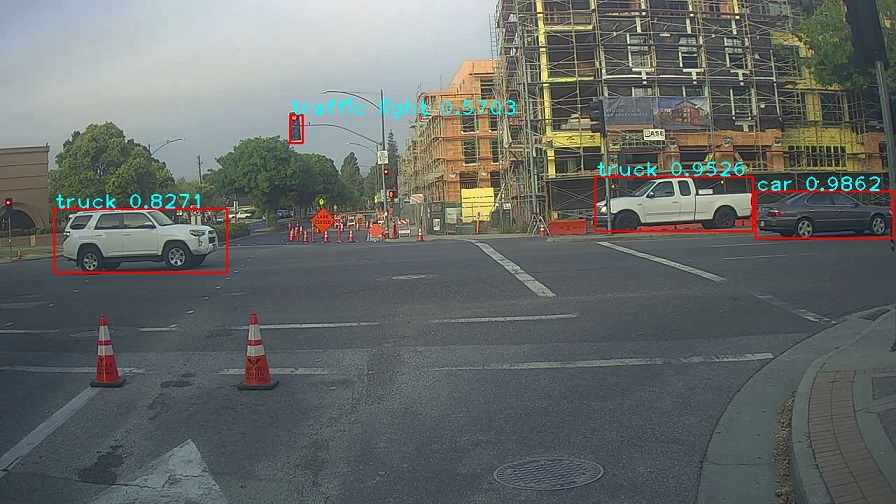

In [40]:
from IPython.display import Image, display
display(Image(filename='detected-images/3.jpeg', embed=True))

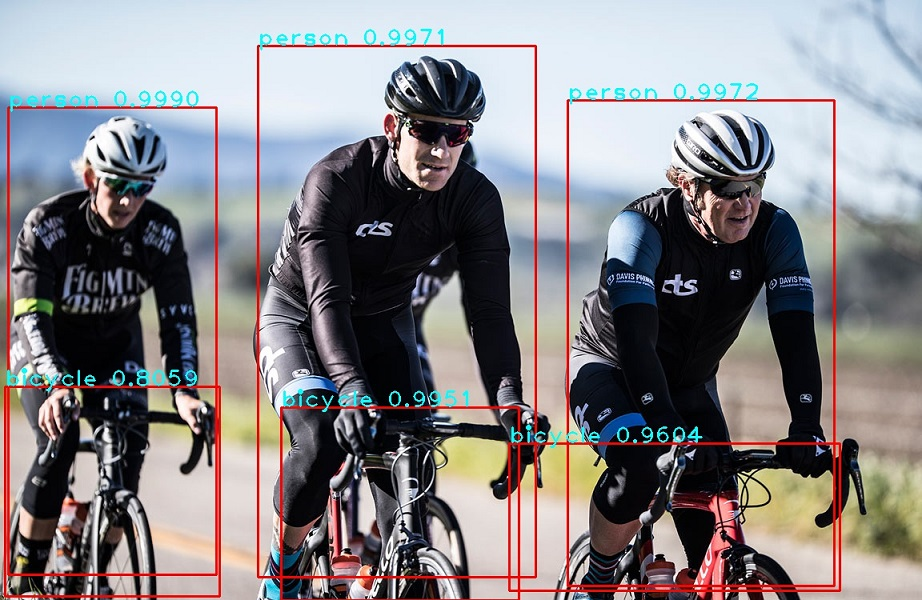

In [41]:
display(Image(filename='detected-images/1.jpeg', embed=True))

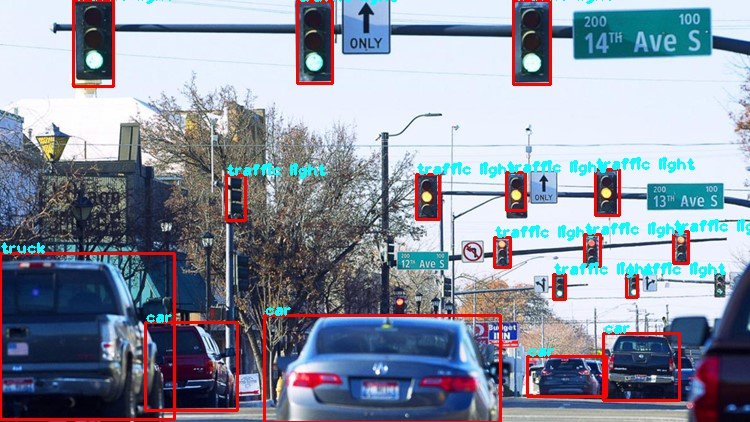

In [42]:
display(Image(filename='detected-images/4.jpeg', embed=True))

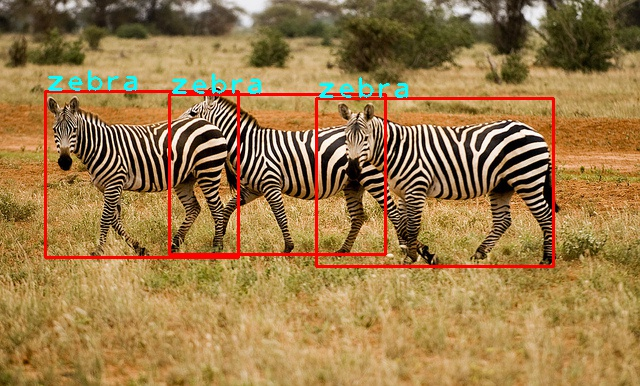

In [43]:
display(Image(filename='detected-images/2.jpeg', embed=True))

## Detecting objects in a video

In [ ]:
win_name = 'Yolov3 detection'
cv2.namedWindow(win_name)
#specify the vidoe input.
# 0 means input from cam 0.
# For vidio, just change the 0 to video path
cap = cv2.VideoCapture('img/road_video.mp4')
frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH),
                  cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
try:
    while True:
        start = time.time()
        ret, frame = cap.read()
        if not ret:
            break
        resized_frame = tf.expand_dims(frame, 0)
        resized_frame = resize_image(resized_frame, (model_size[0],model_size[1]))
        pred = model.predict(resized_frame)
        boxes, scores, classes, nums = bounding_boxes( \
            pred, model_size,
            max_output_size=max_output_size,
            max_output_size_per_class=max_output_size_per_class,
            iou_threshold=iou_threshold,
            confidence_threshold=confidence_threshold)
        img = draw_boxes(frame, boxes, scores, classes, nums, class_names)
        cv2.imshow(win_name, img)
        stop = time.time()
        seconds = stop - start
        # print("Time taken : {0} seconds".format(seconds))
        # Calculate frames per second
        fps = 1 / seconds
        print("Estimated frames per second : {0}".format(fps))
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
finally:
    cv2.destroyAllWindows()
    cap.release()
    print('Detections have been performed successfully.')


## Detected objects in a video

Driving video after running through the YOLOv3 object detection algorithm is given below.
Cars, trucks, traffic signals, persons and fire hydrants are most of the objects detected in run time.

Please watch video at this dir: Object-Detection-with-YOLOv3/det-vid

In [10]:
%%HTML
<video width="580" height="380" controls>
  <source src="det-vid/driving-objects_detection.mp4" type="video/mp4">
</video>